## Outline

* Downloading dataset (CIFAR10)
* `Dataloader` in `torch.utils`
* Visualising images
* Single and multiple convolutional layers
* LeNet
* Training LeNet
* Training on GPU
* Simple visualisation
* Exercises

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## Data loading

In [9]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())#im transforming to tensor so i can use pytorch

# Dataset available     https://www.cs.toronto.edu/~kriz/cifar.html

Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)# here im giving images in batch size of 4 and make it suffle so that same image not send repeatedly

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()#return both image and labels

print(images.shape)

print(images[1].shape)# 4 is batch size, 3 is RGB, 23*32 is shape of image
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
4


## Visualise data

In [13]:
img = images[1]# will plot image at indel 1 in classes
print(type(img))

<class 'torch.Tensor'>


In [14]:
npimg = img.numpy()
print(npimg.shape)

(3, 32, 32)


In [15]:
npimg = np.transpose(npimg, (1, 2, 0))# changing the place
print(npimg.shape)

(32, 32, 3)


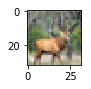

In [16]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [0]:
def imshow(img):#making class for ploting 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

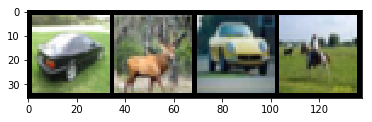

car deer car horse


In [18]:
imshow(torchvision.utils.make_grid(images))#will take the images in batch size of 4 and stack tham together plot
print(' '.join(classes[labels[j]] for j in range(4)))

## Single Convolutional Layer

In [0]:
import torch.nn as nn

class FirstCNN(nn.Module):
    def __init__(self): 
        super(FirstCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1), stride=(2,2)) # padding=(1,1), stride=(2,2))# 3 means three input channel RGB, 16 means 16 channel output each, 3 means size of kernal
        
    def forward(self, x):
        x = self.conv1(x)
        return x

In [0]:
net = FirstCNN()

In [21]:
out = net(images)#SINCE initial size of image was 32,32
out.shape

torch.Size([4, 16, 16, 16])

Last two 16*16 is the size of output image

middel 16 means 16 channel output each

4 is batch size

In [22]:
for param in net.parameters():
    print(param.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])


Each kernal have one bias for each kernal that is 16

Lase 3,3 is size of output image

first 3 is RGB

In [23]:
out1 = out[0, 0, :, :].detach().numpy()
print(out1.shape)

(16, 16)


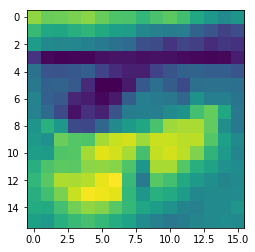

In [24]:
plt.imshow(out[0, 0, :, :].detach().numpy())
plt.show()

## Deep Convolutional Network

In [0]:
class FirstCNN_v2(nn.Module):
    def __init__(self): 
        super(FirstCNN_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, 3),   # (N, 3, 32, 32) -> (N, 8, 30, 30)#no padding so decrease size only by 2
            nn.Conv2d(8, 16, 3)   # (N, 8, 30, 30) -> (N, 16, 28, 28)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

First conv2d output is 8 channel that is input for second layer conv2d

In [26]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

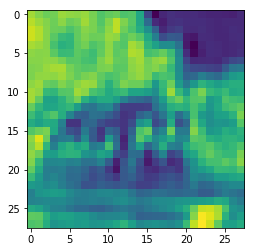

In [0]:
plt.imshow(out[0, 0, :, :].detach().numpy())#0 image(first indel in classes) and 0 channel(r,g,b)

In [0]:
class FirstCNN_v3(nn.Module):
    def __init__(self): 
        super(FirstCNN_v3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)#avgpooling does not change channel size
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [28]:
net = FirstCNN_v3()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

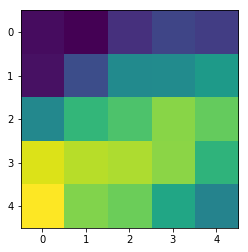

In [29]:
plt.imshow(out[0, 0, :, :].detach().numpy())#pixel size is very large 5*5

## LeNet

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)# applying flattening operation then activation
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)#applying flattening than activation
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)#final flattening
        )
        
    def forward(self, x):
        print(x.shape)
        x = self.cnn_model(x)# first CNN model
        print(x.shape)
        x = x.view(x.size(0), -1)# Reshaping into one dientional N,
        print(x.shape)
        x = self.fc_model(x)#here im not doing softmax necause i need visualization but for calculating losss, we need softmax
        print(x.shape)
        return x

In [33]:
net = LeNet()
out = net(images)

torch.Size([4, 3, 32, 32])
torch.Size([4, 16, 5, 5])
torch.Size([4, 400])
torch.Size([4, 10])


In [34]:
print(out)

tensor([[-0.1136,  0.0577, -0.1102, -0.0709,  0.0064, -0.0693, -0.0048, -0.0313,
         -0.1218, -0.0264],
        [-0.1142,  0.0527, -0.1097, -0.0669, -0.0166, -0.0603, -0.0087, -0.0445,
         -0.1371, -0.0297],
        [-0.1214,  0.0457, -0.1027, -0.0704, -0.0180, -0.0731, -0.0075, -0.0319,
         -0.1185, -0.0267],
        [-0.1104,  0.0533, -0.0989, -0.0563, -0.0049, -0.0770, -0.0147, -0.0280,
         -0.1209, -0.0260]], grad_fn=<AddmmBackward>)


In [35]:
max_values, pred_class = torch.max(out.data, 1)
print(pred_class)

tensor([1, 1, 1, 1])


## Training LeNet

In [0]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [37]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
net = LeNet()

In [0]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 37.45, Train acc: 37.42
Epoch: 1/16, Test acc: 42.16, Train acc: 42.80
Epoch: 2/16, Test acc: 45.33, Train acc: 46.35
Epoch: 3/16, Test acc: 47.72, Train acc: 49.14
Epoch: 4/16, Test acc: 49.03, Train acc: 51.38
Epoch: 5/16, Test acc: 51.84, Train acc: 54.06
Epoch: 6/16, Test acc: 52.28, Train acc: 55.32
Epoch: 7/16, Test acc: 52.82, Train acc: 56.93
Epoch: 8/16, Test acc: 52.83, Train acc: 57.61
Epoch: 9/16, Test acc: 54.33, Train acc: 59.70
Epoch: 10/16, Test acc: 54.16, Train acc: 60.07
Epoch: 11/16, Test acc: 54.06, Train acc: 60.98
Epoch: 12/16, Test acc: 54.66, Train acc: 62.18
Epoch: 13/16, Test acc: 53.89, Train acc: 63.06
Epoch: 14/16, Test acc: 54.49, Train acc: 63.17
Epoch: 15/16, Test acc: 55.38, Train acc: 65.01


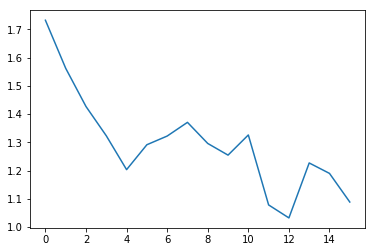

CPU times: user 9min 46s, sys: 12.5 s, total: 9min 59s
Wall time: 10min 1s


In [41]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()#optimizer automatic taking all backword steps
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

## Move to GPU

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)#move to device
        outputs = net(inputs)# whenever call net, first give input to LeNet
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
net = LeNet().to(device)#move to device
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())

In [45]:
%%time
max_epochs = 16

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
    print('Epoch: %d/%d' % (epoch, max_epochs))

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 2min 22s, sys: 3.33 s, total: 2min 25s
Wall time: 2min 26s


In [46]:
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

Test acc: 56.11, Train acc: 65.27


## Basic Visualisation

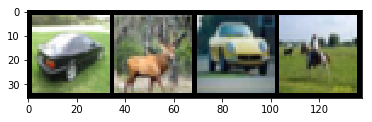

In [48]:
imshow(torchvision.utils.make_grid(images))

In [0]:
net = net.to('cpu')#move to cpu

In [51]:
out = net(images)
print(out.shape)

torch.Size([4, 10])


In [52]:
out = net.cnn_model[0](images)# you can print layer wise output, here im printing output of layer 1
out.shape

torch.Size([4, 6, 28, 28])

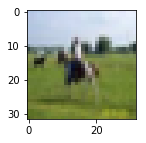

In [54]:
image_id = 3
plt.figure(figsize = (2,2))
imshow(images[image_id,])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


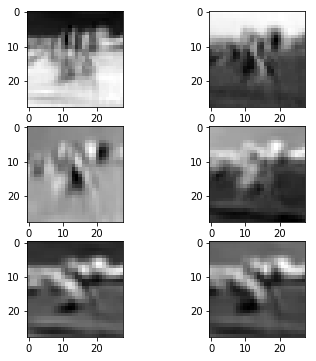

In [55]:
plt.figure(figsize = (6,6))
plt.subplot(321)
for i in range(6):
    ax1 = plt.subplot(3, 2, i+1)
    plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()

## Exercises

* Modify LeNet to work with ReLU instead of Tanh -> What is the impact on training time, final loss
* We have observed over-fitting -> Use weight_decay in torch.optim to add L2 regularisation
* Instead of CIFAR10, use the MNIST data available from `torchvision.datasets.MNIST`. Download and visualise MNIST data.
* But importantly MNIST images have only 1 channel instead of 3 channels in the case of CIFAR10. Modify LeNet to work with MNIST. Train and find optimised test accuracy.